# 0. Functions

In [ ]:
import numpy as np
from shapely.geometry import Point
from shapely.ops import cascaded_union

!pip install rtree
!pip install geopandas
import rtree
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import folium, folium.plugins
from folium import plugins, FeatureGroup, LayerControl, Map
from folium.plugins import HeatMap, MarkerCluster, FeatureGroupSubGroup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def df_cleaner(df, year=None):
    """This function cleans geo-coded data frames by separating the field "Coordinates" into two fields: "Latitude" and "longitude"
    """
    df_clean = df.dropna(axis=0, subset = ['Coordinates'])
    df_clean['Latitude'] = [eval(i)[0] for i in df_clean['Coordinates']]
    df_clean['Longitude'] = [eval(i)[1] for i in df_clean['Coordinates']]
    print()
    print('Number of available data in', str(year)+':', df_clean.shape)
    print('Proportion of available data in', str(year)+':', round(df_clean.shape[0]/df.shape[0], 3))
    print()
    return df_clean

In [5]:
# ~ 8 seconds
def assign_ward(df, ward):
  '''This function assigns each dots in the dataset to the ward it belongs to. 
  '''
  # 1: Group the data by same addresses
  df_temp = df.groupby(['Latitude', 'Longitude'])[[]].count().reset_index()

  # 2: Restructure a geometry column of each data point
  geometry = [Point(xy) for xy in zip(df_temp['Longitude'], df_temp['Latitude'])]
  crs = {'init':'epsg:4326'}
  geo_df_temp = gpd.GeoDataFrame(df_temp, crs=crs, geometry=geometry)

  # 3: Spatial join of points and wards
  joined = gpd.sjoin(geo_df_temp, ward, how="left")

  df_new = pd.merge(df, joined[['Latitude', 'Longitude', 'index_right', 'id', 'name']], how='left', on=['Latitude', 'Longitude'])
  return df_new

In [71]:
def geo_choropleth(df, ward, on='id', value='RecordId', location=[40.767937,-73.982155], tiles="cartodbpositron", name=None):
  new_ward = pd.merge(ward, df.groupby(on)[[value]].count().reset_index(), on=on, how='left')
  new_ward.loc[new_ward[value].isnull(), value] = 0.01
  # new_ward[value+'_Proportion'] = round(100*new_ward[value]/df.shape[0], 2)
  new_ward[value+'_mean'] = round(new_ward[value]/new_ward['area'], 2)
  
  import branca
  import branca.colormap as cm
  #colormap = cm.linear.YlGnBu_09.to_step(data=new_ward[value+'_mean'], method='quant', quantiles=[0, 0.1, 0.2, 0.5, 0.8, 0.9, 1])
  colormap = cm.linear.YlGnBu_09.scale(vmin=min(new_ward[value+'_mean']), vmax=max(new_ward[value+'_mean']))
  colormap.caption = "Number of Residents per Square KM in Each Ward"

  map = folium.Map(location=location, zoom_start=12, tiles=None)
  base_map = FeatureGroup(name='Base Map', overlay=True, control=False)
  folium.TileLayer(tiles=tiles).add_to(base_map)
  base_map.add_to(map)

  style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties'][value+'_mean']), 
                            'fillOpacity':0.75}
  highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
  
  folium.GeoJson(new_ward,
    style_function=style_function,
    control=True, overlay=True, name='Choropleth',
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(fields=[on, value, 'area', value+'_mean'],
    aliases=['Ward:','Population:', 'Area (square km):', "Population per square km:"],
    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
    sticky=True)).add_to(map)
    
  colormap.add_to(map)
  folium.LayerControl(collapsed=False).add_to(map)

  if name is not None:
    base_map.save(r'choropleth_'+name+'.html')
    print('Map saved.')
  return map

In [72]:
def geo_choropleth_compare(ward, df_compare=None, on='id', value='RecordId', vmin=200, vmax=100000, location=[40.767937,-73.982155], 
                           tiles="cartodbpositron", name=None):
  import branca
  import branca.colormap as cm

  if df_compare is None:
    year_list = [1940,1930,1920,1910,1900,1880]
    df_compare = {}
    for year in year_list:
      df_compare[str(year)+'_population'] = eval('df_'+str(year)+'_clean')

  map = folium.Map(location=location, zoom_start=12, tiles=None)
  base_map = FeatureGroup(name='Base Map', overlay=True, control=False)
  folium.TileLayer(tiles=tiles).add_to(base_map)
  base_map.add_to(map)
  colormap = cm.linear.YlGnBu_09.scale(vmin=vmin, vmax=vmax)

  for k, df in df_compare.items():
    layer = FeatureGroup(name=k, overlay=False)
    new_ward = pd.merge(ward, df.groupby(on)[[value]].count().reset_index(), on=on, how='left')
    new_ward.loc[new_ward[value].isnull(), value] = 0.01
    new_ward[value+'_mean'] = round(new_ward[value]/new_ward['area'],2)
    
    style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties'][value+'_mean']), 
                            'fillOpacity':0.75}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
    folium.GeoJson(new_ward,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(fields=[on, value, 'area', value+'_mean'],
        aliases=['Ward:','Population:', 'Area (square km):', "Population per square km:"],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        sticky=True)).add_to(layer)
    layer.add_to(map)

  colormap.add_to(map)
  folium.LayerControl(collapsed=False).add_to(map)

  if name is not None:
    base_map.save(r'choropleth_'+name+'.html')
    print('Map saved.')

  return map

In [76]:
def choropleth_field_compare(df, ward, field, on='id', value='RecordId',vmin=0, vmax=50000, location=[40.767937, -73.982155], tiles='cartodbpositron', name=None):
  df.dropna(axis=0, subset=[field], inplace=True)
  d = {}
  for v in df.groupby(field)[['RecordId']].count().reset_index().sort_values(by='RecordId', ascending=False)[field].tolist()[:10]:
    d[v] = df[df[field]==v]
  return geo_choropleth_compare(ward, d, on, value, vmin, vmax, location, tiles, name)

In [78]:
def choropleth_v_compare(ward, field, v, on='id', value='RecordId',vmin=0, vmax=50000, location=[40.767937, -73.982155], tiles='cartodbpositron', name=None):
  year_list = [1940,1930,1920,1910,1900,1880]
  d = {}
  for year in year_list:
    df = eval('df_'+str(year)+'_clean')
    d[str(year)+'_'+field+' is '+v] = df[df[field]==v]
  return geo_choropleth_compare(ward, d, on, value, vmin, vmax, location, tiles,name)

# 1. Preparation

## 1.1 Choose Maps of Wards

http://bklyn-genealogy-info.stevemorse.org/Ward/

**Map 1. Manhattan wards from 1700s to 1800s.**

In [ ]:
wards = gpd.read_file('/content/drive/MyDrive/Maps_Functions/nyc-wards.geojson')

**Map 2. Manhattan enumeration districts in 1900s.**

In [ ]:
wards_1900 = gpd.read_file('/content/drive/MyDrive/Maps_Functions/enumeration-districts.geojson')

In [ ]:
location=[40.767937,-73.982155]
tiles="cartodbpositron"

map = folium.Map(location=location, tiles=None, zoom_start=12)
base_map = FeatureGroup(name='Base Map', overlay=True, control=False)
folium.TileLayer(tiles=tiles).add_to(base_map)
base_map.add_to(map)

for name, group in wards.groupby(['validSince', 'validUntil']):
  layer = FeatureGroup(name=name, overlay=False)
  temp = wards[(wards['validSince']==name[0])&(wards['validUntil']==name[1])]
  folium.Choropleth(geo_data=temp, fill_color='lightblue',
                    fill_opacity=0.7, highlight=True,
                    line_opacity=0.2,).add_to(layer)
  layer.add_to(map)

folium.LayerControl(collapsed=False).add_to(map)
map

In [ ]:
location=[40.767937,-73.982155]
tiles="cartodbpositron"

map = folium.Map(location=location, tiles=tiles, zoom_start=12)
folium.Choropleth(geo_data=wards_1900, fill_color='lightblue',
                    fill_opacity=0.7,
                    line_opacity=0.2,).add_to(map)
map

**Problems：**
- Enumeration districts map is valid in 1900s. But it doesn't cover the complete area of Manhattan. And the districts are too small/meticulous to be used in a choropleth map.
- Wards maps are only valid in 1800s. The most suitbale map is valid from 1850 to 1895, which matches with our 1880 census dataset. However, the rest datasets (1900, 1910, 1920, 1930 and 1940) do not match this ward map in respect to time.

**For the following choropleth maps, we will use the ward map which is valid from 1853 to 1895.**

In [ ]:
wards2 = wards[(wards['validSince']==1853)&(wards['validUntil']==1895)]

## 1.2 Load Raw Data

In [ ]:
path_of_wards = '/content/drive/MyDrive/Maps_Functions/nyc-wards.geojson'
wards = gpd.read_file(path_of_wards)
wards2 = wards[(wards['validSince']==1853)&(wards['validUntil']==1895)]

# calculate the area in square kilometers of each ward
wards2['area'] = round(wards2['geometry'].to_crs({'proj': 'cea'}).map(lambda p: p.area / 10**6), 2)

In [ ]:
path = '/content/drive/MyDrive/geocoded_clean_data/'
df_1940 = pd.read_csv(path + 'geocoded_census_1940.csv')
df_1930 = pd.read_csv(path + 'geocoded_census_1930.csv')
df_1920 = pd.read_csv(path + 'geocoded_census_1920.csv')
df_1910 = pd.read_csv(path + 'geocoded_census_1910.csv')
df_1900 = pd.read_csv(path + 'geocoded_census_1900.csv')
df_1880 = pd.read_csv(path + 'geocoded_census_1880.csv')

In [ ]:
df_1940_clean = df_cleaner(df_1940, 1940)
df_1930_clean = df_cleaner(df_1930, 1930)
df_1920_clean = df_cleaner(df_1920, 1920)
df_1910_clean = df_cleaner(df_1910, 1910)
df_1900_clean = df_cleaner(df_1900, 1900)
df_1880_clean = df_cleaner(df_1880, 1880)

## 1.3 Assign wards

In [ ]:
df_1940_clean = assign_ward(df_1940_clean, wards2)
df_1930_clean = assign_ward(df_1930_clean, wards2)
df_1920_clean = assign_ward(df_1920_clean, wards2)
df_1910_clean = assign_ward(df_1910_clean, wards2)
df_1900_clean = assign_ward(df_1900_clean, wards2)
df_1880_clean = assign_ward(df_1880_clean, wards2)

# 2. Use Cases

## 2.1 Colorbar Setting

In [13]:
wards_1940 = pd.merge(wards2, df_1940_clean.groupby('id')[['RecordId']].count().reset_index(), on='id', how='left')

In [14]:
wards_1940['RecordId_log'] = [np.log(i) for i in wards_1940['RecordId']]
wards_1940['RecordId_mean'] = round(wards_1940['RecordId']/wards_1940['area'])

In [15]:
wards_1940.head()

,id,name,type,validSince,validUntil,geometry,area,RecordId,RecordId_log,RecordId_mean
0,1853-1895-1,1,st:Ward,1853,1895,"POLYGON ((-74.01792 40.71212, -74.01859 40.712...",1.17,2528,7.835184,2161.0
1,1853-1895-2,2,st:Ward,1853,1895,"POLYGON ((-74.00452 40.70503, -74.00304 40.704...",0.38,106,4.663439,279.0
2,1853-1895-3,3,st:Ward,1853,1895,"POLYGON ((-74.00859 40.71140, -74.00589 40.714...",0.64,1137,7.036148,1777.0
3,1853-1895-4,4,st:Ward,1853,1895,"POLYGON ((-73.99981 40.70585, -73.99569 40.706...",0.43,3090,8.035926,7186.0
4,1853-1895-5,5,st:Ward,1853,1895,"POLYGON ((-74.00589 40.71468, -74.00188 40.719...",0.95,321,5.771441,338.0


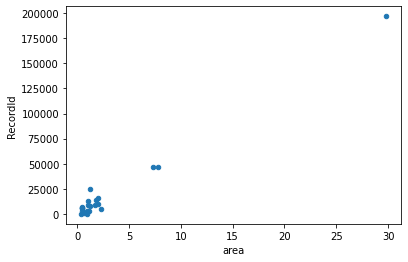

In [25]:
wards_1940[['RecordId', 'area']].sort_values(by='area').reset_index()[['RecordId', 'area']].plot.scatter(x='area', y='RecordId')

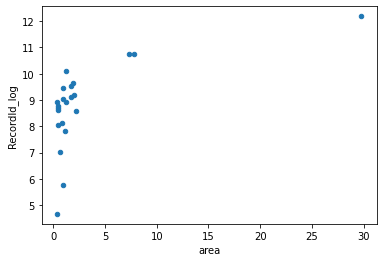

In [26]:
wards_1940[['RecordId_log', 'area']].sort_values(by='area').reset_index()[['RecordId_log', 'area']].plot.scatter(x='area', y='RecordId_log')

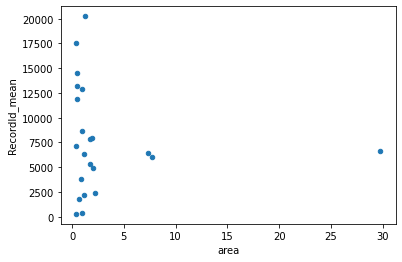

In [27]:
wards_1940[['RecordId_mean', 'area']].sort_values(by='area').reset_index()[['RecordId_mean', 'area']].plot.scatter(x='area', y='RecordId_mean')

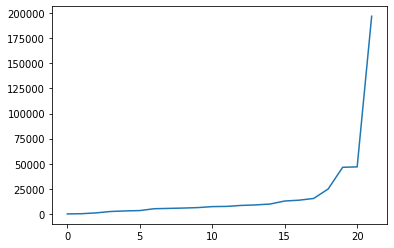

In [39]:
wards_1940['RecordId'].sort_values().reset_index()['RecordId'].plot()

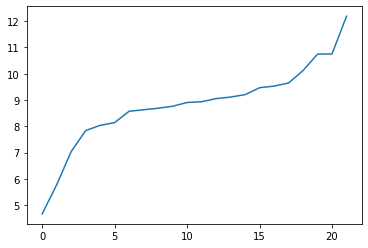

In [16]:
wards_1940['RecordId_log'].sort_values().reset_index()['RecordId_log'].plot()

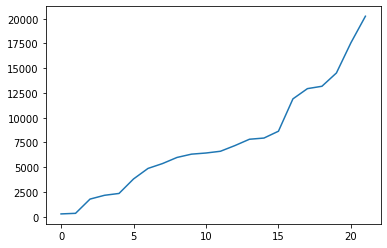

In [ ]:
wards_1940['RecordId_mean'].sort_values().reset_index()['RecordId_mean'].plot()

From the above charts, we can see that:
- The total number of residents in each ward varies a lot across different wards. The top three wards with the largest area also have the most number of residents. The largest ward has number of residents more than 10 times than a normal ward. Hence the total numbers are influenced greatly by the area.
- The log of number of residents varies relatively smoothly compared to the last one. But the top three wards are still influeced by their areas and become outliers.
- The number of residents per square km is the best to tell the population of different wards, without being biasly influenced by their areas. Hence we will use the number of residents per square km as a threshold to set the following colorbars.

In [33]:
colormap = cm.linear.YlGnBu_09.scale(vmin=min(wards_1940['RecordId_mean']), vmax=max(wards_1940['RecordId_mean']))
colormap

In [ ]:
colormap = cm.linear.YlGnBu_09.to_step(n=6, data=wards_1940['RecordId_mean'], method='linear')
colormap

In [29]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlGnBu_09.to_step(data=wards_1940['RecordId_mean'], method='quant', quantiles=[0, 0.25, 0.5, 0.75, 1])
colormap

For simplicity and consistency, we will use the first type of colormap (**scale**).

## 2.2 Map Functions

### 2.2.1 Choropleth Map

In [73]:
geo_choropleth(df_1940_clean, wards2, name='1940')

Map saved.


In [74]:
geo_choropleth(df_1930_clean,wards2, name='1930')

Map saved.


- The above Choropleth Map shows the population of residents in 1930 by splitting data points into wards they belong to. The color of each ward indicates the number of residents per square kilometers, which matches the color bar on the upper-right.
- By touching upon the ward, a pop-up window will tell the corresponding ward name, population, area in square km, and the population per square km. 

### 2.2.2 Compare Choropleth Maps

In [75]:
geo_choropleth_compare(wards2, name='all', vminn=200, vmax=100000)

Map saved.


- In order to compare the population across different datasets, the above map allows us to control layers of choropleth maps using the layer control panel.
- One issue to notice is that, since each Choropleth Map can only adopt one color bar, the different layers of maps need to share the same color bar. Hence the color-coding of wards in each layer will be different from maps with only one layer. (2.2.1)
  - You can set **vmin** and **vmax** parameters to adjust the color bar. In order for the color bar to be adaptive to all layers, **vmax** should be roughly the maximum population (per square km) among all wards in these datasets. Similarly, **vmin** should be the minimum population. 
  - As a result, we can easily compare the population (per square km) of each ward across the time.
  - On the other hand, in some layers, the wards are more "similar" in their colors and difficult to tell the difference, such as *1940_population*, since wards in 1940 have relatively low population (per suqare km) compare to others.
- Another potential issue is that **the map of wards is changing over time**. In these maps, we are using the same unified map across all the time, since there are no better map files to adopt. However, if different datasets could be matched with maps of wards by their time, the statistics and visualization might be more exacting and meaningful.

### 2.2.3 Compare Choropleth Map of Different Values in Specified Field

In [77]:
choropleth_field_compare(df_1930_clean, wards2, field='Race', vmin=0, vmax=50000, name='compare_race')

Map saved.


### 2.2.4 Compare Choropleth Map of Specified Value by Time

In [79]:
choropleth_v_compare(wards2, 'Race', 'Black', vmin=0, vmax=4000, name='race_black')

Map saved.


In [83]:
choropleth_v_compare(wards2, 'Race', 'White', vmin=0, vmax=90000, name='race_white')

Map saved.


- From the two maps, we can see that Black residents were tending to live in the northern ward starting from 1920, whilte White residents were mainly living around the southeeast wards as centers.
- It's also noteworthy that: 
  - Before 1920, the overall population were concentrated in the sourthern wards, which were probably due to northern part of Manhattan wasn't much developed at early times. Starting from 1910, the overall population began to move from south to the north.
  - But when we look by race, White and Black residents still show distinct signs of population centers in the south and north, despite that in 1930s and 1940s the north has been developed much more than earlier. 
  - This may suggest signs of segregation by different races. 

# Appendix.

In [ ]:
gpd_choro = pd.merge(wards, df_1940_choro, left_on='name', right_on='Region')

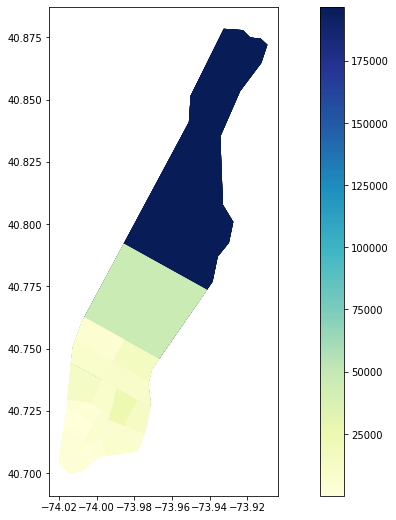

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
gpd_choro.plot(ax=ax, column='RecordId', cmap='YlGnBu', k=3, legend=True)

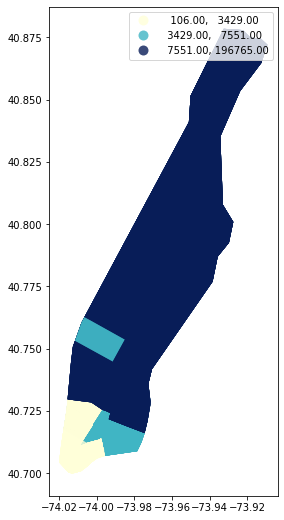

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
gpd_choro.plot(ax=ax, column='RecordId', cmap='YlGnBu', scheme='quantiles', k=3,alpha=0.8, legend=True)